# Young People Survey
Exploring the hobbies and interests of young people

In this day and age, where we are increasingly connected online, we are also ironically increasingly disconnected in real life. With this trend in the backdrop, we think that we can help young people find other like-minded people and recommend them new hobbies that they can engage in to find fulfilment.

In this notebook, we will do so with the following methods:
* K Means Clustering with dimensionality reduction - the outcome of this machine learning is to group young people with overlaps of multiple hobby groups
* Graphing and graph clustering algorithms - the outcome of this machine learning is to give suggestions to young people of what are other hobbies, which could be within the same hobby cluster, that can they can consider to find new friends.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Get the current working directory
file_path = os.getcwd()

# Join the directory with the filename
full_path = os.path.join(file_path, 'responses.csv')

# Read the CSV file
df = pd.read_csv(full_path)


# Data Exploration of Young People Survey Responses

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Columns: 150 entries, Music to House - block of flats
dtypes: float64(134), int64(5), object(11)
memory usage: 1.2+ MB
None


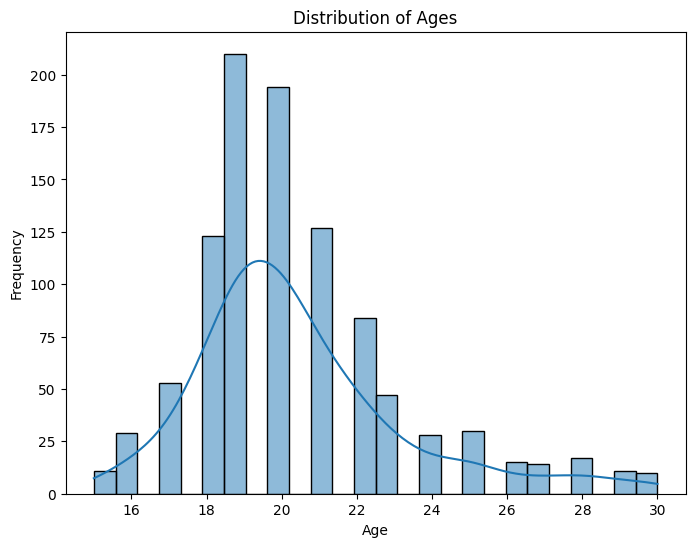

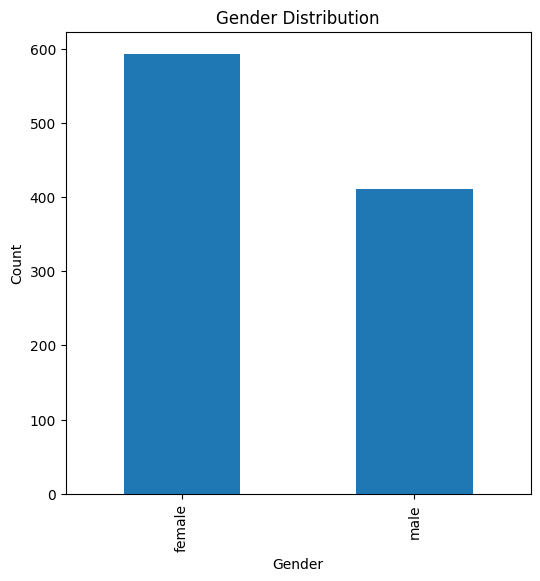

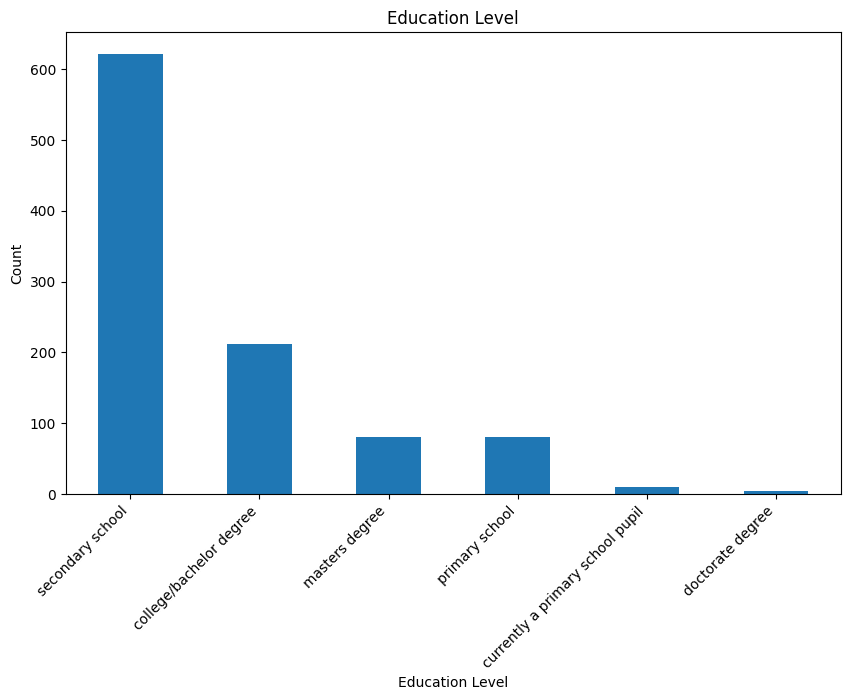

In [3]:
# explore the wider dataset and plot basic info of participants

# Print some basic info
print(df.info())

# Plot the distribution of ages
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], kde=True)
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Plot the gender distribution
plt.figure(figsize=(6, 6))
df['Gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Plot the distribution of education levels
plt.figure(figsize=(10, 6))
df['Education'].value_counts().plot(kind='bar')
plt.title('Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.show()

# Truncating and preprocessing of dataset
Now we proceed to pick out only the hobbies and interests which are our columns of interest

In [4]:
# Select columns which are Hobbies and Interests: 'History' to 'Pets' (inclusive)

hobbies_df = df.loc[:, 'History':'Pets']

# fill the na rows in each column in hobbies dataframe with the median of each column
for col in hobbies_df.columns:
    hobbies_df[col] = hobbies_df[col].fillna(hobbies_df[col].median())

hobbies = hobbies_df.copy()

# Further exploration of truncated dataset

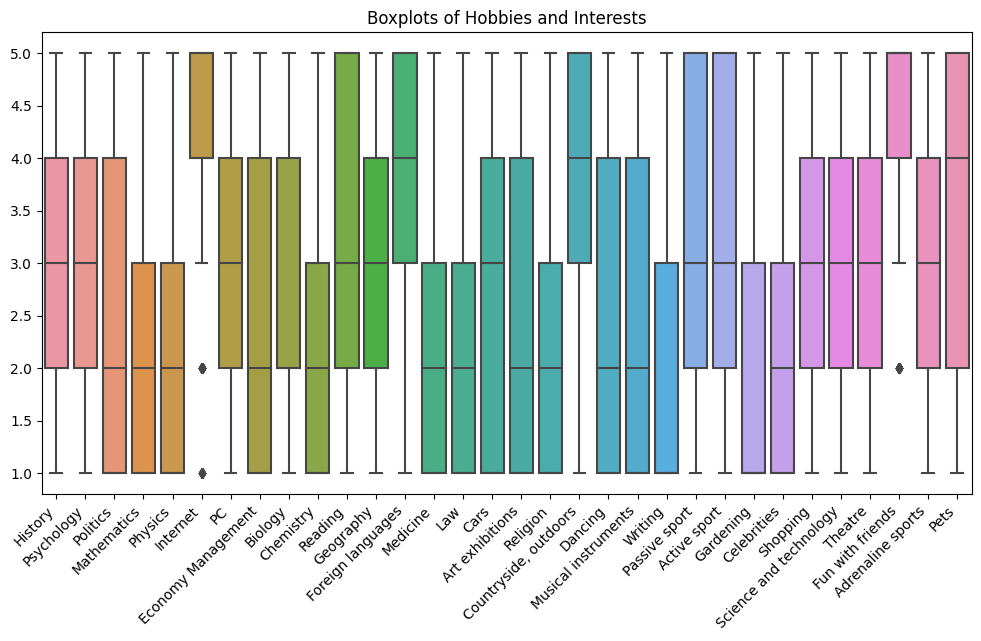

In [5]:
# exploring the hobbies data using boxplots

plt.figure(figsize=(12, 6))
sns.boxplot(data=hobbies_df)
plt.xticks(rotation=45, ha='right')
plt.title('Boxplots of Hobbies and Interests')
plt.show()


Through the boxplots, we notice that most of the responses lie within 2 to 4 which is expected for a likert scale type survey question. The notable exceptions are Internet and Fun with Friends which are skewed towards the higher scores

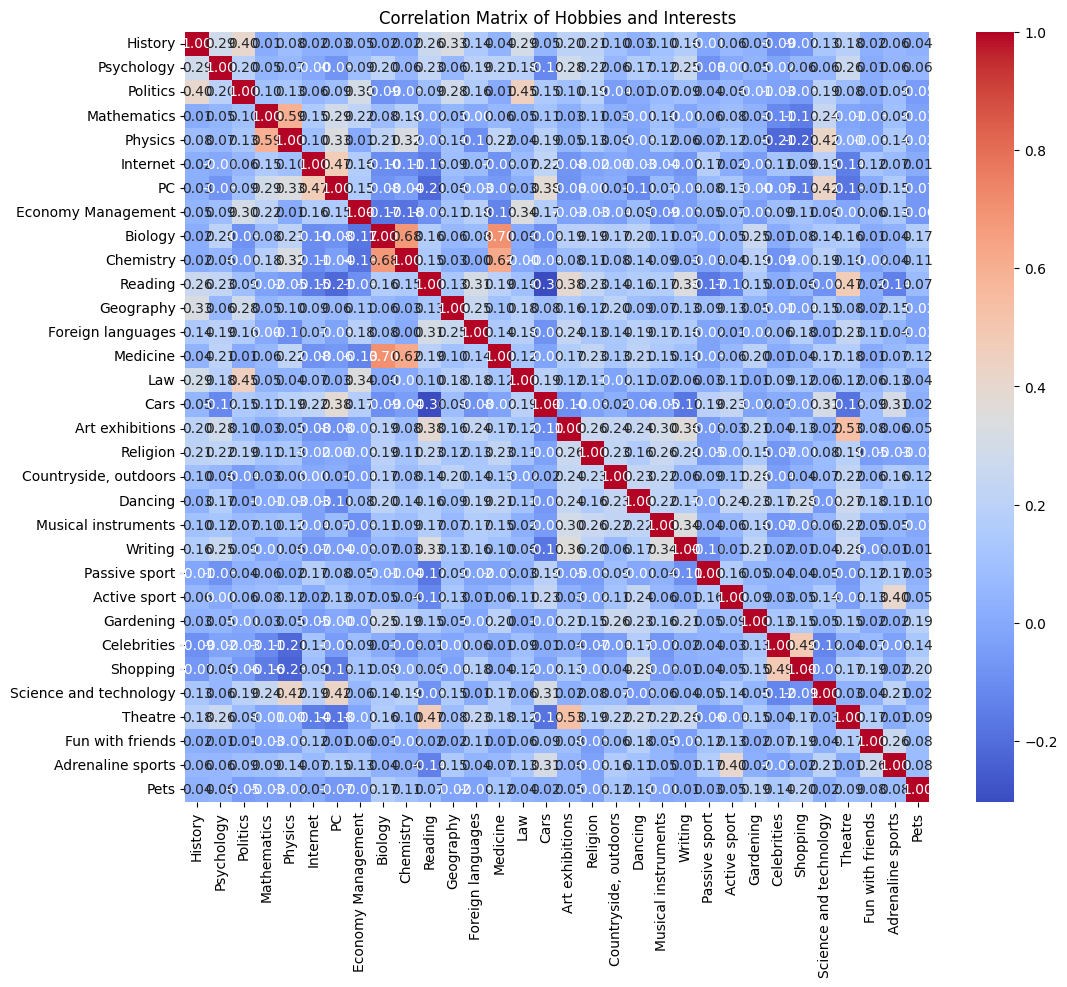

,Hobby 1,Hobby 2,Correlation
0,PC,PC,1.0
1,Writing,Writing,1.0
2,Religion,Religion,1.0
3,Physics,Physics,1.0
4,Art exhibitions,Art exhibitions,1.0
5,Fun with friends,Fun with friends,1.0
6,Foreign languages,Foreign languages,1.0
7,Psychology,Psychology,1.0
8,Celebrities,Celebrities,1.0
9,History,History,1.0


In [6]:
#identifying correlated hobbies and interests to look out for possible hobby groupings or to drop off some hobbies from the list

# Calculate the correlation matrix
corr_matrix = hobbies.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Hobbies and Interests')
plt.show()

# Find the top 10 correlated pairings
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
# Exclude self-correlations (e.g., 'History' with 'History')
corr_pairs = corr_pairs[corr_pairs != 1]

top_10_corr = []
seen_pairs = set()

for pair, corr in corr_pairs.items():
    col1, col2 = pair
    # Check if the pair (or its reverse) has been seen before
    if (col1, col2) not in seen_pairs and (col2, col1) not in seen_pairs:
        top_10_corr.append((col1, col2, corr))
        seen_pairs.add((col1, col2)) # Add both to seen_pairs
        if len(top_10_corr) == 10:
            break

# Display the top 10 correlated pairings in a table
top_10_df = pd.DataFrame(top_10_corr, columns=['Hobby 1', 'Hobby 2', 'Correlation'])
top_10_df

From the above exploration, it can be seen that most of the hobbies are not very highly correlated, hence there aren't any clear groupings to be made unless we use low correlation thresholds.

We hence did not drop any features using correlations scores but we will drop Internet and Fun with Friends because they are generally rated with high scores which gives small variance.

In [7]:
# Remove 'Internet' and 'Fun with friends' from the hobbies DataFrame
hobbies = hobbies.drop(columns=['Internet', 'Fun with friends'])

# Clustering using K Means method
Initialization is done using K means ++ method

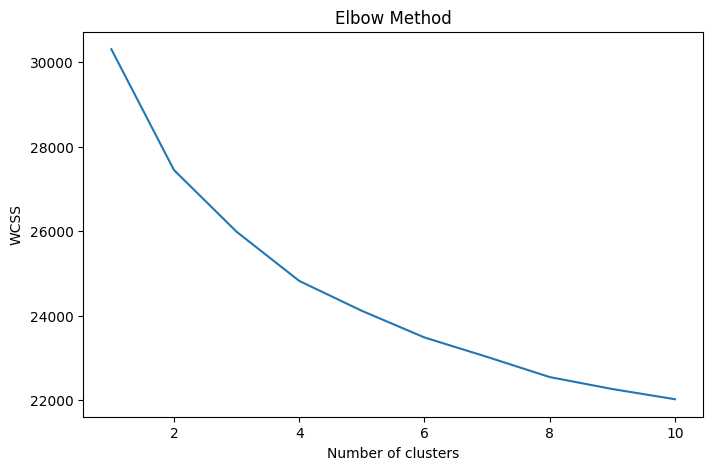

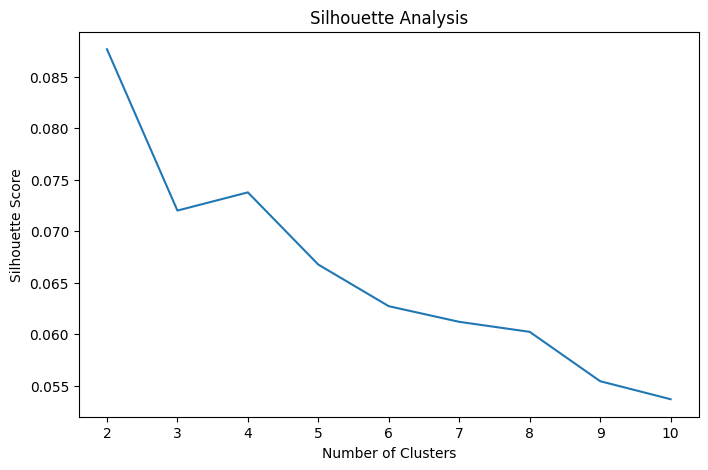

2    316
1    265
3    255
0    174
Name: cluster, dtype: int64
0.07376411098954248


In [8]:
# apply k means clustering on hobbies
# use elbow method to arrive at the optimal number of clusters
# use silhouette score to test performance

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
scaled_hobbies = scaler.fit_transform(hobbies)

# Elbow method and K-means++ initialization
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_hobbies)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silhouette analysis
silhouette_scores = []
for i in range(2, 11):  # Silhouette score is not defined for 1 cluster
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_labels = kmeans.fit_predict(scaled_hobbies)
    silhouette_avg = silhouette_score(scaled_hobbies, kmeans_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Based on the Elbow and Silhouette methods, choose the optimal number of clusters
# Example: Let's say the optimal number of clusters is 4 (you should determine this visually)
optimal_k = 4  # Replace with your chosen optimal k

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(scaled_hobbies)
labels = kmeans.labels_

# Add cluster labels to the hobbies DataFrame
hobbies_type1 = hobbies.copy()
hobbies_type1['cluster'] = labels

# Analyze the clusters (example: count members in each cluster)
print(hobbies_type1['cluster'].value_counts())
print(silhouette_scores[2])

# K-means clustering with prior dimensionality reduction

The K means clustering produces a silhouette_score of 0.074. Using the following guide below, we can conclude that the clusters are poorly defined. But the chosen number of clusters is already the most optimal based on elbow method. This means that the current results from the survey with regards to Hobbies and Interests does not allow the algorithm to generate clearly defined clusters.

*   Above 0.5: indicates that clusters are well-defined and separated;
*   0.3 to 0.5: Indicates that the clusters may be overlapping but can still be considered reasonably well-separated;
*   Below 0.3: Suggests that the clusters are poorly defined and may indicate that the chosen number of clusters is inappropriate for the data.

We will try dimensionality reduction via Truncated SVD to check if this increases the silhouette_score and hence the clustering.

In [9]:
# use svd dimensionality reduction and choose the number of dimension that keeps 80% of the total energy
# perform kmeans clustering again
# along with elbow method and silhouette score
from sklearn.decomposition import TruncatedSVD

# using the same scaled_hobbies from the previous code
# Calculate Truncated SVD
svd = TruncatedSVD(n_components=scaled_hobbies.shape[1] - 1) #n_components must be < n_features
svd.fit(scaled_hobbies)

# Explained variance ratio
explained_variance_ratio = svd.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find the number of components to retain 80% of variance
n_components = np.argmax(cumulative_variance >= 0.8) + 1

# Apply dimensionality reduction
svd = TruncatedSVD(n_components=n_components)
reduced_hobbies = svd.fit_transform(scaled_hobbies)
reduced_hobbies.shape

(1010, 17)

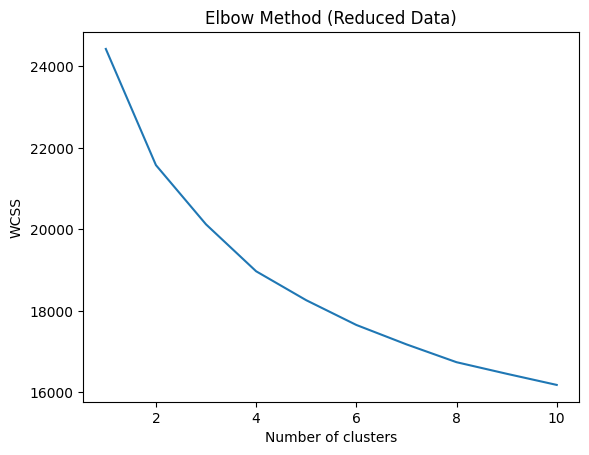

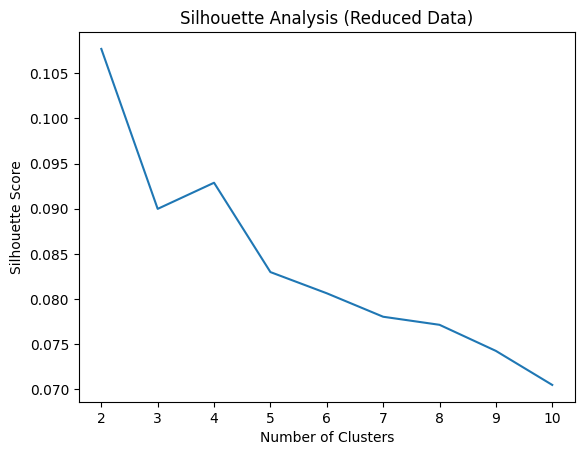

2    313
1    260
0    252
3    185
Name: cluster, dtype: int64
0.09287154049564486


In [26]:
# conducting performance analysis on the reduced dimension clusters
# Elbow method and silhouette analysis on reduced data
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(reduced_hobbies)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method (Reduced Data)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_labels = kmeans.fit_predict(reduced_hobbies)
    silhouette_avg = silhouette_score(reduced_hobbies, kmeans_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Analysis (Reduced Data)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Choose optimal k based on the new plots
optimal_k = 4  # Replace with the new optimal k

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(reduced_hobbies)
labels = kmeans.labels_
hobbies_type2 = hobbies.copy()
hobbies_type2['cluster'] = labels
print(hobbies_type2['cluster'].value_counts())
print(silhouette_scores[2])

Compared to the K means clustering done without Truncated SVD, this clustering attempt performs slightly better, producing a silhouette_score of 0.093. However, this is still a very low score and we will not arrive at any well defined clusters.

We will proceed to further trim down the original dataset of hobbies and interests such that that only cover a specific aspect of hobbies for example only including Arts & Culture, Outdoor Activities and Mathematics & Sciences. With this, we expect the clusters to be clearer and more well-defined.

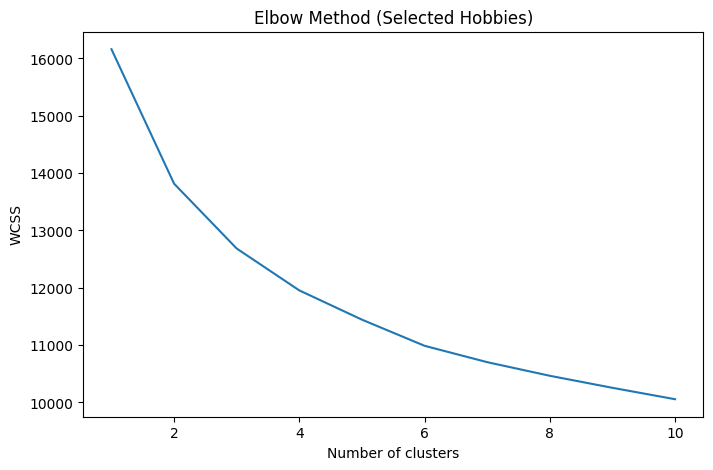

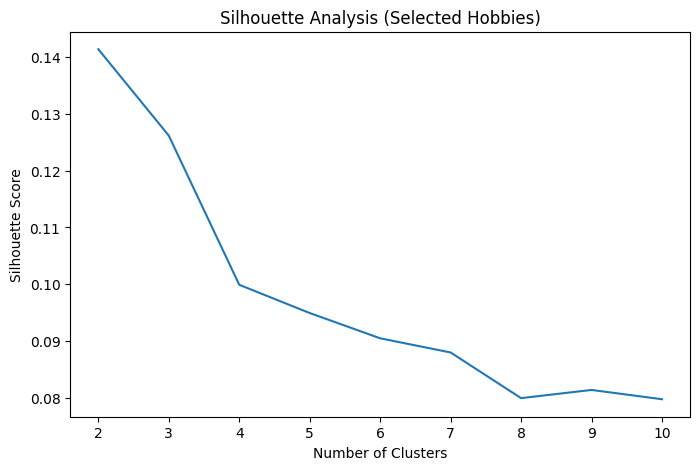

1    454
0    314
2    242
Name: cluster, dtype: int64
0.12619355320609751


In [27]:
# select only hobbies belonging to Arts & Culture, Outdoor activities and Mathematics & Sciences
# run k means clustering and select optimal number of clusters

# Select only the specified hobbies
selected_hobbies = hobbies_df[['Art exhibitions', 'Writing', 'Theatre', 'Reading', 'Dancing', 'Musical instruments', 'Countryside, outdoors', 'Gardening', 'Active sport'
, 'Passive sport', 'Adrenaline sports', 'Mathematics', 'Physics', 'Biology', 'Chemistry', 'Medicine']]

# Scale the data
scaler = StandardScaler()
scaled_selected_hobbies = scaler.fit_transform(selected_hobbies)

# Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_selected_hobbies)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method (Selected Hobbies)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silhouette analysis
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_labels = kmeans.fit_predict(scaled_selected_hobbies)
    silhouette_avg = silhouette_score(scaled_selected_hobbies, kmeans_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Analysis (Selected Hobbies)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Determine the optimal number of clusters based on the plots
optimal_k = 3 # Example, replace with your observation

# Apply KMeans clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(scaled_selected_hobbies)
labels = kmeans.labels_
hobbies_type3 = selected_hobbies.copy()
hobbies_type3['cluster'] = labels

# Print the silhouette score for the optimal k
print(hobbies_type3.loc[:, 'cluster'].value_counts())
print(silhouette_scores[1])

Indeed as expected by narrowing down the hobby groups to just the 3 identified, we have managed to improve the clustering once again, this time producing a silhouette_score of 0.097.

While this is not a high score, we will explore through visualisation whether we can make sense of the clustering which the K-Means algorithm has performed. We do so by visualising the average ratings of the hobbies of each cluster and visualising it on a heatmap.

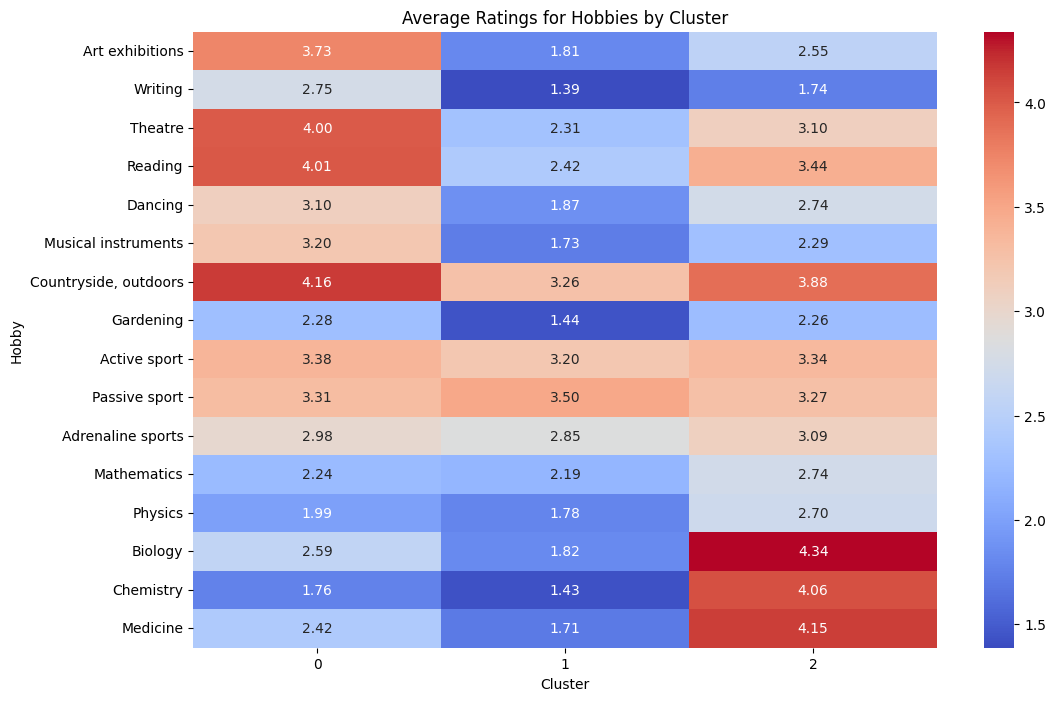

In [29]:
# computing the average ratings of these hobbies amongst each cluster and visualising using warm to cool colors heatmap

# Calculate the average rating for each hobby in hobbies_type3
average_ratings = hobbies_type3.groupby('cluster').mean()

# Transpose the DataFrame for the heatmap
average_ratings = average_ratings.T

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(average_ratings, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Average Ratings for Hobbies by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Hobby')
plt.show()

From the heatmap visualisation above, we can tell that each of the clusters have some defining characteristics which allows us to tell them apart from their average ratings.

We further explore another form of exploration which is a 3D plot. We will group the selected hobbies into hobby groups which we previously used to select them in the first place.

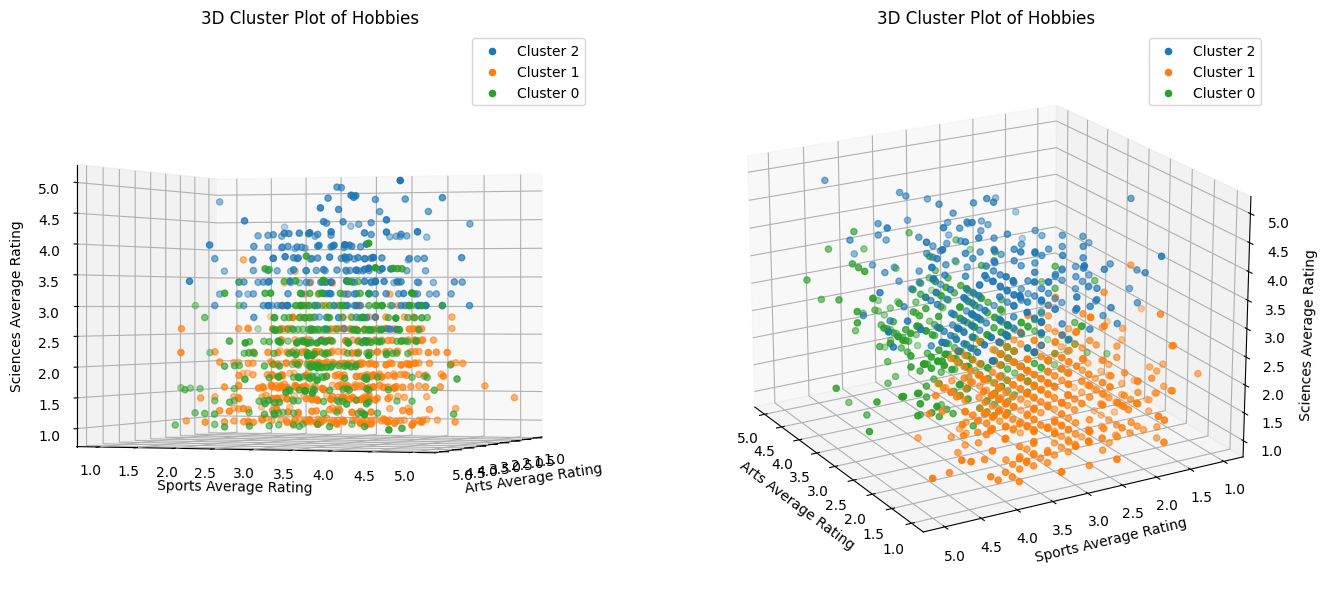

In [30]:
# we group the selected hobbies into Arts & Culture, Outdoor Activities and Mathematics & Sciences respectively
# we visualise these hobby groups on a 3D plot

from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121, projection='3d')
bx = fig.add_subplot(122, projection='3d')

# Group data by cluster
arts_indices = selected_hobbies.columns.get_indexer(['Art exhibitions', 'Writing', 'Theatre', 'Reading', 'Dancing', 'Musical instruments'])
sports_indices = selected_hobbies.columns.get_indexer(['Countryside, outdoors', 'Gardening', 'Active sport', 'Passive sport', 'Adrenaline sports'])
science_indices = selected_hobbies.columns.get_indexer(['Mathematics', 'Physics', 'Biology', 'Chemistry', 'Medicine'])

for cluster in hobbies_type3['cluster'].unique():
    cluster_data = hobbies_type3[hobbies_type3['cluster'] == cluster]

    # Calculate the average ratings for arts and sports to use as coordinates
    arts_avg = np.mean(cluster_data.iloc[:, arts_indices], axis=1)
    sports_avg = np.mean(cluster_data.iloc[:, sports_indices], axis=1)
    science_avg = np.mean(cluster_data.iloc[:, science_indices], axis=1)


    ax.scatter(arts_avg, sports_avg, science_avg, label=f"Cluster {cluster}")
    bx.scatter(arts_avg, sports_avg, science_avg, label=f"Cluster {cluster}")


ax.set_xlabel('Arts Average Rating')
ax.set_ylabel('Sports Average Rating')
ax.set_zlabel('Sciences Average Rating')
ax.set_title('3D Cluster Plot of Hobbies')
ax.legend()
ax.view_init(elev=0, azim=20)  # Adjust the elevation and azimuth angles as needed to observe the split of the clusters better

bx.set_xlabel('Arts Average Rating')
bx.set_ylabel('Sports Average Rating')
bx.set_zlabel('Sciences Average Rating')
bx.set_title('3D Cluster Plot of Hobbies')
bx.legend()
bx.view_init(elev=20, azim=150)  # Adjust the elevation and azimuth angles as needed to observe the split of the clusters better

plt.show()

From the scatterplots above, we observe that the 3 clusters generated might not be distinctly apart but we have some indications on where their interests lie.

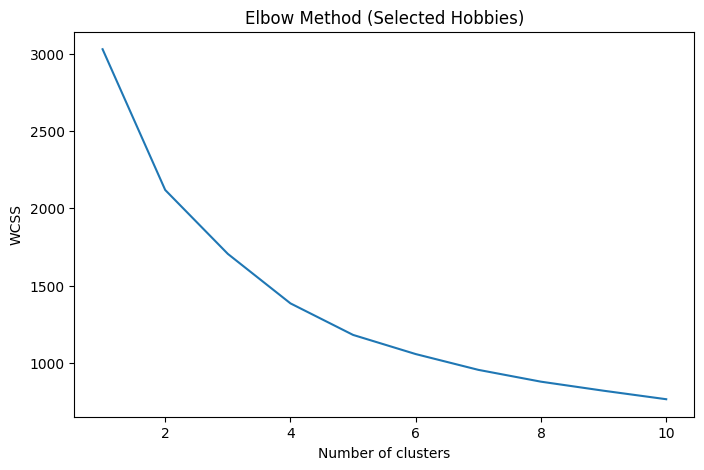

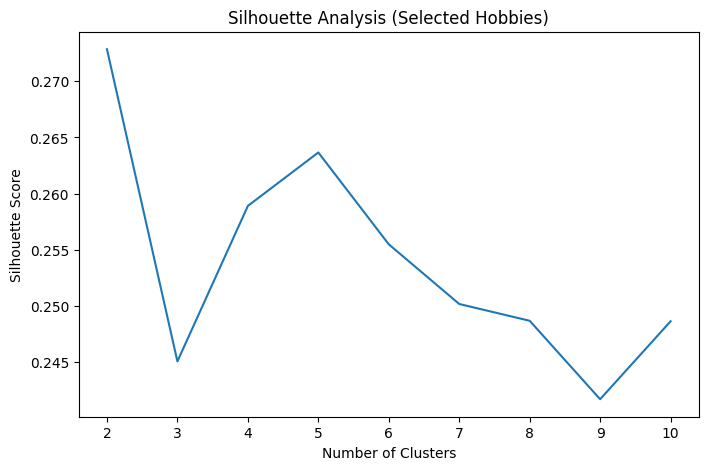

1    358
0    342
2    310
Name: cluster, dtype: int64
0.2450484831387388


In [31]:
# grouping the columns into 3 columns
# run k means clustering and select optimal number of clusters

# Calculate the means for the three groups of columns
arts_mean = hobbies_type3[['Art exhibitions', 'Writing', 'Theatre', 'Reading', 'Dancing', 'Musical instruments']].mean(axis=1)
outdoors_mean = hobbies_type3[['Countryside, outdoors', 'Gardening', 'Active sport', 'Passive sport', 'Adrenaline sports']].mean(axis=1)
science_mean = hobbies_type3[['Mathematics', 'Physics', 'Biology', 'Chemistry', 'Medicine']].mean(axis=1)

# Create a new DataFrame with the means
result_df = pd.DataFrame({'Arts': arts_mean,
                          'Outdoors': outdoors_mean,
                          'Science': science_mean})

# Scale the data
scaler = StandardScaler()
scaled_result = scaler.fit_transform(result_df)

# Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_result)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method (Selected Hobbies)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silhouette analysis
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_labels = kmeans.fit_predict(scaled_result)
    silhouette_avg = silhouette_score(scaled_result, kmeans_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Analysis (Selected Hobbies)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Determine the optimal number of clusters based on the plots
optimal_k = 3 # Example, replace with your observation

# Apply KMeans clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(scaled_result)
labels = kmeans.labels_
hobbies_type4 = result_df.copy()
hobbies_type4['cluster'] = labels

# Print the silhouette score for the optimal k
print(hobbies_type4.loc[:, 'cluster'].value_counts())
print(silhouette_scores[1])

With this grouped columns, we have managed to improve the clustering more substantially, this time producing a silhouette_score of 0.245. This is still not a very clearly defined clustering result.

However, we should ultimately not expect a very high silhouette_score since in reality everyone's interest is varied. The likelihood for a clustering to show very clearly defined clusters will be very low and hence this reflects in the silhouette_score.

Let us still proceed to see how the 3D plot looks.

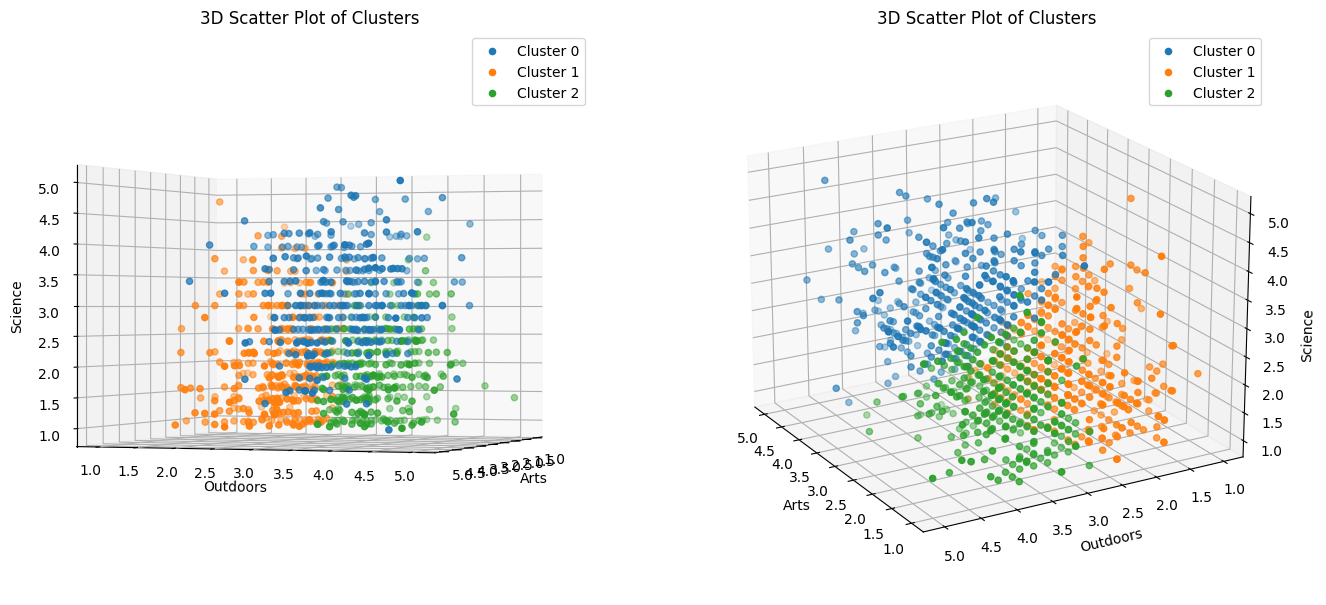

In [33]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121, projection='3d')
bx = fig.add_subplot(122, projection='3d')

# Scatter plot the data points with color-coded clusters
for cluster in hobbies_type4['cluster'].unique():
    cluster_data = hobbies_type4[hobbies_type4['cluster'] == cluster]
    ax.scatter(cluster_data['Arts'], cluster_data['Outdoors'], cluster_data['Science'], label=f'Cluster {cluster}')
    bx.scatter(cluster_data['Arts'], cluster_data['Outdoors'], cluster_data['Science'], label=f'Cluster {cluster}')

ax.set_xlabel('Arts')
ax.set_ylabel('Outdoors')
ax.set_zlabel('Science')
ax.set_title('3D Scatter Plot of Clusters')
ax.legend()
ax.view_init(elev=0, azim=20)  # Adjust the elevation and azimuth angles as needed to observe the split of the clusters better

bx.set_xlabel('Arts')
bx.set_ylabel('Outdoors')
bx.set_zlabel('Science')
bx.set_title('3D Scatter Plot of Clusters')
bx.legend()
bx.view_init(elev=20, azim=150)  # Adjust the elevation and azimuth angles as needed to observe the split of the clusters better

plt.show()

From these two scatterplots, we can tell the 3 clusters apart more clearly compared to the previous scatterplots above.

Through the above code, we have employed 2 different types of algorithms:
1. For point clustering algorithm, we have employed K Means clustering.
2. For dimensionality reduction algorithm, we have employed truncated SVD.

For the purposes of exploring clustering beyond the Jupyter notebook, there are 2 more methods which I could employ to derive different clustering results. They are:
1.   PCA - Principal Component Analysis: which is another dimensionality reduction technique which simplifies the complexity of high-dimensional data while retaining the most important features. It transforms the original variables into a new set of variables called principal components.
2.   GMM - Gaussian Mixture Models: This model is probabilistic and assumes that the data is generated from a mixture of several Gaussian distributions. GMM can be used for clustering the young people using their hobbies data with the assumption they are Gaussian PDFs. GMMs allow for more flexibility than K-means allowing for each datapoint to potentially fall under multiple clusters.



# Graphing and Network Analysis
Instead of diving deeper into either PCA or GMM from dimensionality reduction and clustering respectively, we will employ another type of algorithm from graphs and networks. Using this separate technique, we hope to further explore and understand the survey responses in other useful and meaningful ways.

Average correlation (excluding diagonal): 0.09348842910964818


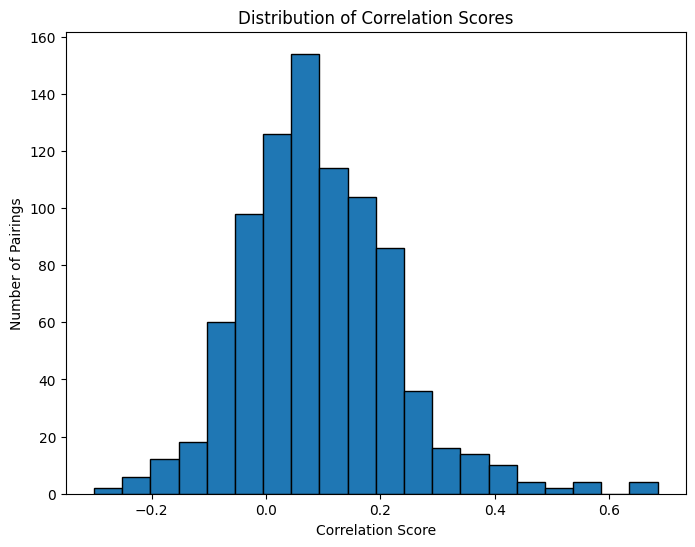

In [16]:
# finding the average correlation of the hobby pairings while ignoring the diagonal correlation scores of 1
# Calculate the Spearman correlation matrix
spearman_corr = hobbies.corr(method='spearman')

# Exclude the diagonal elements
spearman_corr = spearman_corr.mask(np.equal(*np.indices(spearman_corr.shape)))

# Calculate the average correlation (ignoring NaNs introduced by masking)
avg_correlation = np.nanmean(spearman_corr.values)
print(f"Average correlation (excluding diagonal): {avg_correlation}")

# Flatten the correlation matrix and remove NaNs
correlation_scores = spearman_corr.values.flatten()
correlation_scores = correlation_scores[~np.isnan(correlation_scores)]

# Plotting the distribution of correlation scores
plt.figure(figsize=(8, 6))
plt.hist(correlation_scores, bins=20, edgecolor='black')
plt.xlabel('Correlation Score')
plt.ylabel('Number of Pairings')
plt.title('Distribution of Correlation Scores')
plt.show()

After obtaining the correlation scores, we plot the distribution of the correlation scores above.

By observing the distribution above and knowing that the average correlation falls around 0.093, we chose 0.2 as the “Threshold Correlation Score” for us to convert the Likert Scale ordinal data into a graph-like data.

In [17]:
pip install networkx

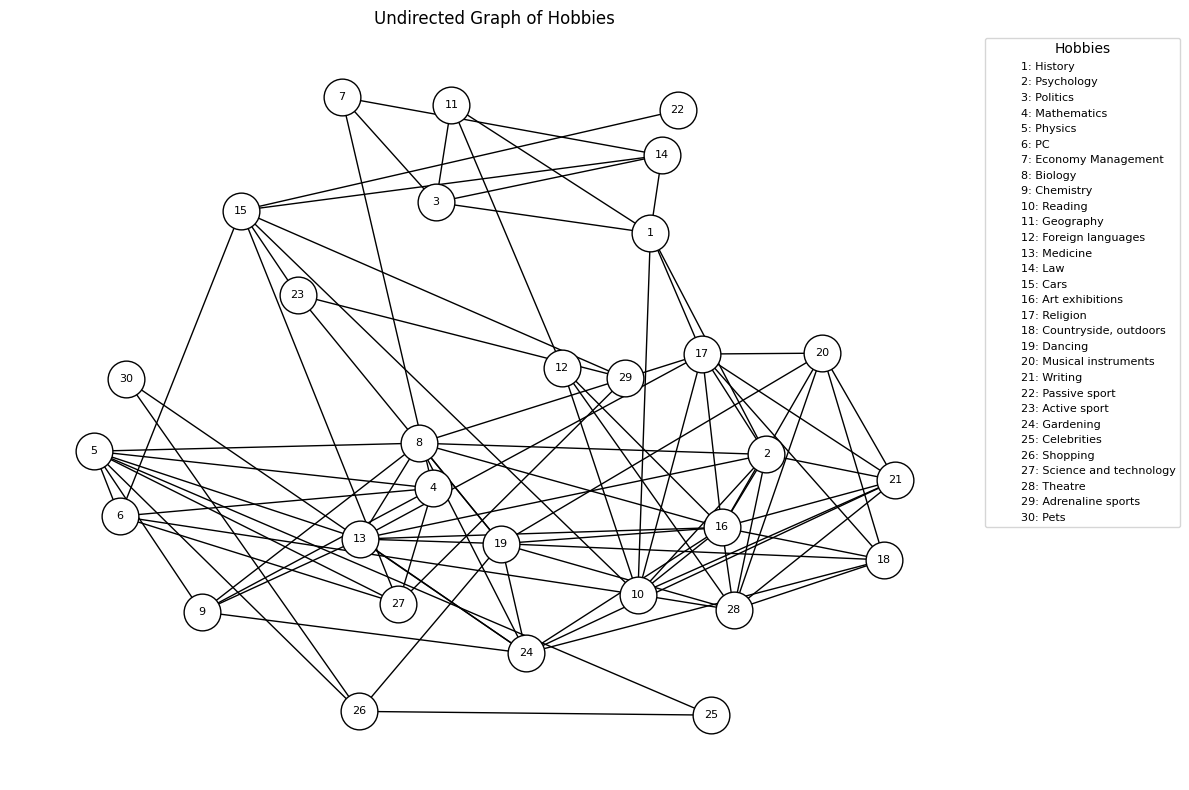

In [18]:
import networkx as nx

# Step 1: Calculate the Spearman correlation matrix
spearman_corr = hobbies.corr(method='spearman')

# Step 2: Create an undirected graph based on the Spearman correlations
threshold = 0.2  # Define a threshold for significant correlations
G = nx.Graph()

# Add edges for significant correlations
for i in range(len(spearman_corr)):
    for j in range(i + 1, len(spearman_corr)):
        if abs(spearman_corr.iloc[i, j]) > threshold:  # Check if the correlation is significant
            G.add_edge(i + 1, j + 1, weight=spearman_corr.iloc[i, j])  # Use numbers as node identifiers

# Ensure all nodes are added to the graph
for i in range(1, len(spearman_corr) + 1):
    G.add_node(i)

# Step 3: Visualize the graph
pos = nx.spring_layout(G, k=1.5, iterations=100)  # Positioning the nodes
plt.figure(figsize=(12, 8))

# Draw nodes with white color and black outline
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='white', edgecolors='black', linewidths=1)

# Draw edges in black
nx.draw_networkx_edges(G, pos, width=1, edge_color='black')

# Create labels for nodes with numbers
labels = {i + 1: f'{i + 1}' for i in range(len(G.nodes()))}  # Numbered labels for nodes
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)  # Reduced font size for labels

# Create a legend with numbered hobbies
hobby_labels = {i: hobbies.columns[i] for i in range(len(hobbies.columns))}  # Map numbers to hobbies
handles = [plt.Line2D([0], [0], color='w', label=f'{i + 1}: {hobby}') for i, hobby in hobby_labels.items()]

# Position the legend outside the graph
plt.legend(handles=handles, title='Hobbies', loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.title('Undirected Graph of Hobbies')
plt.axis('off')  # Hide axes for better visualization
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

For the next step, as with our original intentions of finding hobby clusters so as to give suggestions to young people, we proceed to perform graph clustering using the Louvain Method.

In [19]:
!pip install python-louvain
import community.community_louvain as community_louvain

# Compute the best partition using Louvain clustering
partition = community_louvain.best_partition(G)

# Display the clustering results
# for node, community_id in partition.items():
#     print(f"Node {node} belongs to community {community_id}")

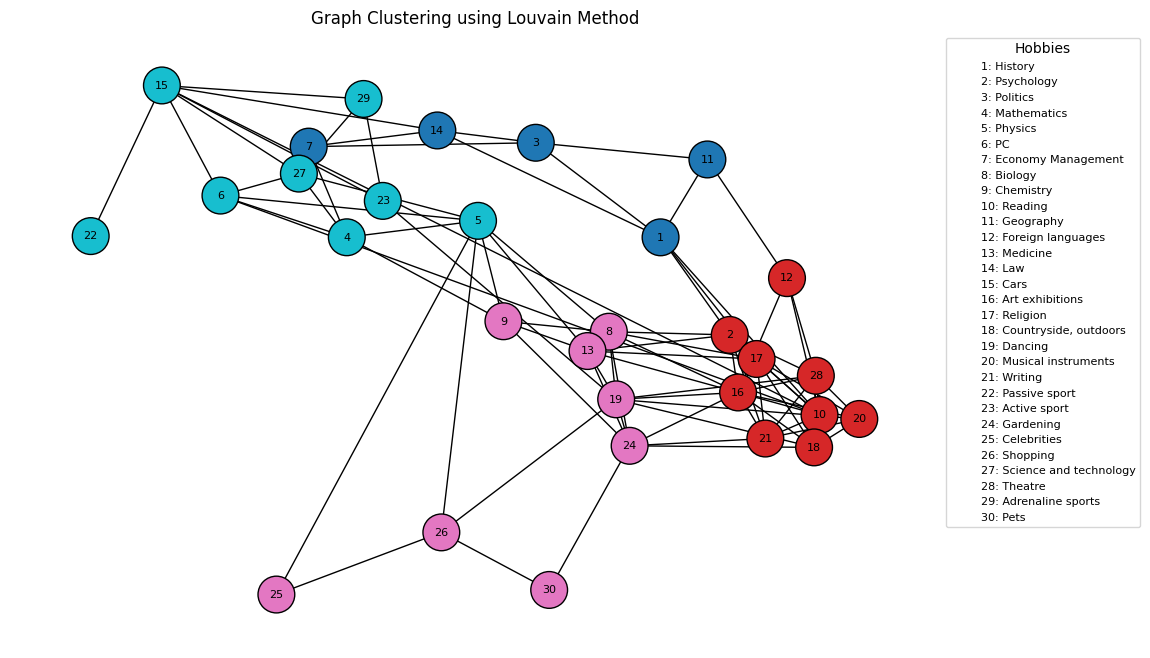

In [20]:
import matplotlib.cm as cm

# Define the spring layout
pos = nx.spring_layout(G, k=1.5, iterations=240)
plt.figure(figsize=(12, 8))

# Map each community to a unique color
unique_communities = set(partition.values())
colors = cm.get_cmap('tab10', len(unique_communities))  # Use a colormap with enough colors for each community
community_colors = {community: colors(i) for i, community in enumerate(unique_communities)}

# Draw nodes with community colors, black outline
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=700,
    node_color=[community_colors[partition[node]] for node in G.nodes()],  # Fill color based on community
    edgecolors='black',  # Black outline for all nodes
    linewidths=1
)

# Draw edges in black
nx.draw_networkx_edges(G, pos, width=1, edge_color='black')

# Draw labels for nodes
nx.draw_networkx_labels(G, pos, font_size=8)

# Create a legend with numbered hobbies
hobby_labels = {i: hobbies.columns[i] for i in range(len(hobbies.columns))}  # Map numbers to hobbies
handles = [plt.Line2D([0], [0], color='w', label=f'{i + 1}: {hobby}') for i, hobby in hobby_labels.items()]

# Position the legend outside the graph
plt.legend(handles=handles, title='Hobbies', loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.title("Graph Clustering using Louvain Method")
plt.axis("off")
plt.show()

In [21]:
# Measuring the performance of the graph clustering performed by the Louvain Method
modularity_score = community_louvain.modularity(partition, G)
print("Modularity Score:", modularity_score)


from networkx.algorithms.cuts import conductance

conductance_scores = []
community_info = []

for community_number, community in enumerate(set(partition.values()), start=1):
    # Get nodes in the current community
    nodes_in_community = [node for node in G.nodes() if partition[node] == community]

    # Calculate conductance score
    conductance_score = conductance(G, nodes_in_community)

    # Append the information to lists
    conductance_scores.append(conductance_score)
    community_info.append({
        'Community Number': community_number,
        'Members': nodes_in_community,
        'Conductance Score': conductance_score
    })

# Print detailed community information
for info in community_info:
    print(f"Community {info['Community Number']}:")
    print(f"  Members: {info['Members']}")
    print(f"  Conductance Score: {info['Conductance Score']}")
    print()

avg_conductance = sum(conductance_scores) / len(conductance_scores)
print("Average Conductance:", avg_conductance)

Modularity Score: 0.5068060864054729
Community 1:
  Members: [1, 3, 11, 14, 7]
  Conductance Score: 0.3

Community 2:
  Members: [2, 10, 17, 16, 21, 28, 12, 18, 20]
  Conductance Score: 0.2753623188405797

Community 3:
  Members: [8, 13, 9, 25, 26, 19, 24, 30]
  Conductance Score: 0.43478260869565216

Community 4:
  Members: [4, 5, 6, 27, 15, 22, 23, 29]
  Conductance Score: 0.2972972972972973

Average Conductance: 0.3268605562083823


From the Modularity Score, which measures the density of edges within communities compared to what would be expected in a random graph, a general guideline is that scores above 0.3 indicate some structure within the graph while scores above 0.5 represent good community structure. With a modularity score of 0.51, we can conclude that the clusters we have obtained are relatively well-defined.

As for conductance, we gather from the conductance scores that Communities 1,2 and 4 are quite well-separated from the rest of the graph given that they have either 0.3 or lower conductance. We observe however that Community 3 has a slightly higher conductance value of 0.43. We will investigate its nodes to understand the high conductance score better.

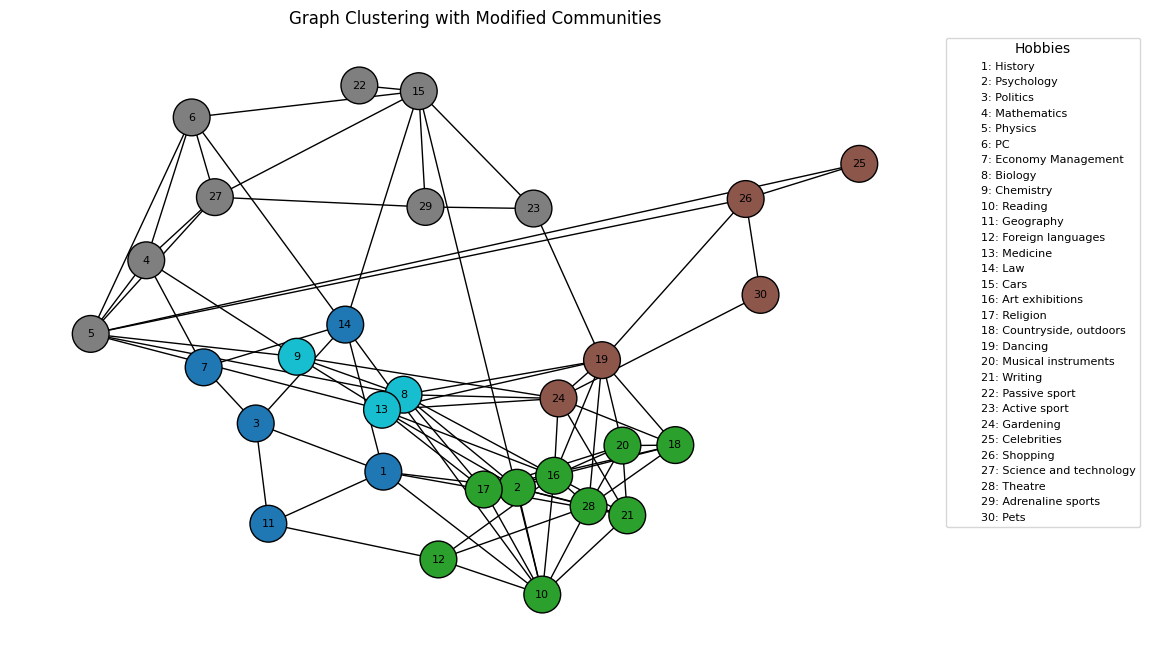

In [22]:
# Assign a new community number for nodes 8, 9, and 13
new_community_id = max(partition.values()) + 1  # This ensures a unique new community ID
partition[8] = new_community_id
partition[9] = new_community_id
partition[13] = new_community_id

# Define the spring layout
pos = nx.spring_layout(G, k=1.5, iterations=240)
plt.figure(figsize=(12, 8))

# Map each community to a unique color
unique_communities = set(partition.values())
colors = cm.get_cmap('tab10', len(unique_communities))  # Ensure colormap has enough colors for each community
community_colors = {community: colors(i) for i, community in enumerate(unique_communities)}

# Draw nodes with community colors, black outline
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=700,
    node_color=[community_colors[partition[node]] for node in G.nodes()],  # Fill color based on community
    edgecolors='black',  # Black outline for all nodes
    linewidths=1
)

# Draw edges in black
nx.draw_networkx_edges(G, pos, width=1, edge_color='black')

# Draw labels for nodes
nx.draw_networkx_labels(G, pos, font_size=8)

# Create a legend with numbered hobbies
hobby_labels = {i: hobbies.columns[i] for i in range(len(hobbies.columns))}  # Map numbers to hobbies
handles = [plt.Line2D([0], [0], color='w', label=f'{i + 1}: {hobby}') for i, hobby in hobby_labels.items()]

# Position the legend outside the graph
plt.legend(handles=handles, title='Hobbies', loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

# Display the plot
plt.title("Graph Clustering with Modified Communities")
plt.axis("off")
plt.show()


In [23]:
# Measuring the performance of the graph clustering performed by the Louvain Method
modularity_score = community_louvain.modularity(partition, G)
print("Modularity Score:", modularity_score)


from networkx.algorithms.cuts import conductance

conductance_scores = []
community_info = []

for community_number, community in enumerate(set(partition.values()), start=1):
    # Get nodes in the current community
    nodes_in_community = [node for node in G.nodes() if partition[node] == community]

    # Calculate conductance score
    conductance_score = conductance(G, nodes_in_community)

    # Append the information to lists
    conductance_scores.append(conductance_score)
    community_info.append({
        'Community Number': community_number,
        'Members': nodes_in_community,
        'Conductance Score': conductance_score
    })

# Print detailed community information
for info in community_info:
    print(f"Community {info['Community Number']}:")
    print(f"  Members: {info['Members']}")
    print(f"  Conductance Score: {info['Conductance Score']}")
    print()

avg_conductance = sum(conductance_scores) / len(conductance_scores)
print("Average Conductance:", avg_conductance)

Modularity Score: 0.4950129794071182
Community 1:
  Members: [1, 3, 11, 14, 7]
  Conductance Score: 0.3

Community 2:
  Members: [2, 10, 17, 16, 21, 28, 12, 18, 20]
  Conductance Score: 0.2753623188405797

Community 3:
  Members: [25, 26, 19, 24, 30]
  Conductance Score: 0.6

Community 4:
  Members: [4, 5, 6, 27, 15, 22, 23, 29]
  Conductance Score: 0.2972972972972973

Community 5:
  Members: [8, 13, 9]
  Conductance Score: 0.7142857142857143

Average Conductance: 0.4373890660847183


This change does not improve the Modularity and Conductance but performs poorly.
Therefore, this change should not be implemented.

This is the end of testing of algorithms to graph and cluster the hobbies dataset but we propose the following extensions that can be further explored on this topic:

1.  We propose that the edges should also be accompanied by their associated correlation value between the paired nodes which shares the same edge
2.	The edge weight can be accounted for when community detection/ clustering is done. This will help to reveal/conserve groups of related topics based on correlation.




# Summary
In this report, we have taken the responses of the young people survey and came with the following recommendations that young people can take reference to:

•	Through dimensionality reduction and point clustering algorithm (K-means), we find out how to group young people who have commonalities amongst multiple hobby groups.

•	Also, with the use of graphing and graph clustering algorithms, we are able to give suggestions to individual young persons on some of the hobbies which they might enjoy given the hobbies’ membership in particular cluster 
groups (or we can refer to as hobby group)
